# Test model

In [1]:
import matplotlib.pyplot as plt
import utils.harry_plotter as harry_plotter
import utils.constants as c
import utils.io as io
import ordinary_training

from learning.datasets import MessengerDataset
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import Accuracy, ConfusionMatrix, F1, MetricCollection, PrecisionRecallCurve
from tqdm import tqdm

In [2]:
MODEL_RUN = 783
BATCH_SIZE = 1024

Load model checkpoint and hyperparameters

In [3]:
model, hparams = ordinary_training.load_model(MODEL_RUN)

Summarize the model

In [4]:
print(model)
summary(model, input_size=(BATCH_SIZE, len(hparams["features"]), hparams["window_size"]), device="cpu")

CRNN(
  (conv_stack): ConvStack(
    (conv0): Conv1d(9, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu0): ReLU()
    (conv1): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (relu1): ReLU()
    (conv2): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (relu2): ReLU()
  )
  (zero_pad): ConstantPad1d(padding=(0, 20), value=0)
  (swap_in): Transposer(dim1=-1, dim2=-2)
  (lstm_stack): RecurrentStack(
    (lstm0): LSTM(128, 32, batch_first=True, bidirectional=True)
    (proj0): Projector(dim=0)
    (lstm1): LSTM(64, 32, batch_first=True, bidirectional=True)
    (proj1): Projector(dim=0)
    (linear): Linear(in_features=64, out_features=5, bias=True)
  )
  (swap_out): Transposer(dim1=-1, dim2=-2)
)


Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     --                        --
├─ConvStack: 1-1                         [1024, 128, 120]          --
│    └─Conv1d: 2-1                       [1024, 128, 120]          3,584
│    └─ReLU: 2-2                         [1024, 128, 120]          --
│    └─Conv1d: 2-3                       [1024, 128, 120]          82,048
│    └─ReLU: 2-4                         [1024, 128, 120]          --
│    └─Conv1d: 2-5                       [1024, 128, 120]          114,816
│    └─ReLU: 2-6                         [1024, 128, 120]          --
├─ConstantPad1d: 1-2                     [1024, 128, 140]          --
├─Transpose: 1-3                         [1024, 140, 128]          --
├─RecurrentStack: 1-4                    [1024, 140, 5]            --
│    └─LSTM: 2-7                         [1024, 140, 64]           41,472
│    └─Projector: 2-8                    [1024, 140, 64]           --

Load test set

In [5]:
ds_test = MessengerDataset(io.resolve_path(c.DATA_DIR),
                           split="test",
                           features=hparams["features"],
                           window_size=hparams["window_size"],
                           future_size=hparams["future_size"],
                           use_orbits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:47<00:00,  6.62it/s]


In [6]:
dl_eval = DataLoader(ds_test, batch_size=BATCH_SIZE)

Define metrics

In [7]:
metrics = MetricCollection({
    "accuracy": Accuracy(num_classes=len(c.CLASSES),
                         compute_on_step=False),
    "macro_f1": F1(num_classes=len(c.CLASSES),
                   average="macro",
                   mdmc_average="global",
                   compute_on_step=False),
    "claccuracy": Accuracy(num_classes=len(c.CLASSES),
                           compute_on_step=False,
                           average="none"),
    "confmat": ConfusionMatrix(num_classes=len(c.CLASSES),
                               compute_on_step=False),
    "prc": PrecisionRecallCurve(num_classes=len(c.CLASSES),
                                compute_on_step=False)
})

/opt/conda/envs/freddie/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Evaluate!

In [8]:
for (x, y) in tqdm(dl_eval, total=len(dl_eval)):
    metrics(softmax(model(x), dim=1), y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9672/9672 [7:24:42<00:00,  2.76s/it]


In [9]:
result = metrics.compute()

In [10]:
import pickle
with open(io.resolve_path(c.TEMP_DIR) / "result.pickle", "wb") as f:
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
result["accuracy"]

tensor(0.9313)

In [12]:
result["macro_f1"]

tensor(0.8195)

In [13]:
result["claccuracy"]

tensor([0.9518, 0.7993, 0.8505, 0.8751, 0.9605])

/root/freddie/src/utils/harry_plotter.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outfile)


<Figure size 432x288 with 0 Axes>

/opt/conda/envs/freddie/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


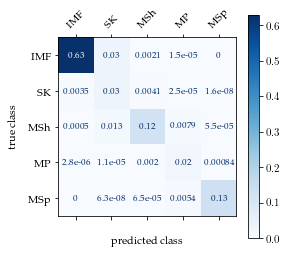

In [84]:
harry_plotter.plot_confusion_matrix(result["confmat"], 
                                    labels=["IMF", "SK", "MSh", "MP", "MSp"], 
                                    outfile=io.resolve_path(c.TEMP_DIR) / "confmat.pdf",
                                    normalize="all")

<Figure size 432x288 with 0 Axes>

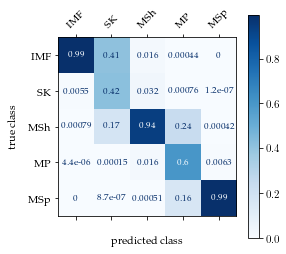

In [85]:
harry_plotter.plot_confusion_matrix(result["confmat"], 
                                    labels=["IMF", "SK", "MSh", "MP", "MSp"], 
                                    outfile=io.resolve_path(c.TEMP_DIR) / "confmat_precision.pdf",
                                    normalize="precision")

<Figure size 432x288 with 0 Axes>

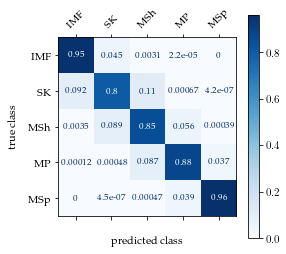

In [86]:
harry_plotter.plot_confusion_matrix(result["confmat"], 
                                    labels=["IMF", "SK", "MSh", "MP", "MSp"], 
                                    outfile=io.resolve_path(c.TEMP_DIR) / "confmat_recall.pdf",
                                    normalize="recall")

In [17]:
precision, recall, thresholds = result["prc"]

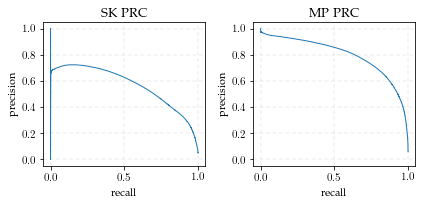

In [98]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
harry_plotter.plot_values(recall[1], precision[1], 
                          ylim=(-0.05, 1.05),
                          xlabel="recall", 
                          ylabel="precision", 
                          title="SK PRC")
plt.subplot(1, 2, 2)
harry_plotter.plot_values(recall[3], precision[3], 
                          ylim=(-0.05, 1.05),
                          xlabel="recall", 
                          ylabel="precision", 
                          title="MP PRC", 
                          outfile=io.resolve_path(c.TEMP_DIR) / "prc.pdf")